# Random Digits Exercise

### Description:
This is an exercise in hypothesis testing, specifically determining if a series of digits [0,9] is random or not. In order to determine this, one has to design and apply statistical tests, from which the degree of consistency of being random can be calculated.

### Your task:
Using tests of your choice/design, determine which of the seven data sets are consistent with being random, and which aren't. One is based on the digits you entered in the course questionaire, while the others range from poor/quasi random to truly random. See if you can determine your (human) dataset.

###  Author: 
 - Troels Petersen ([petersen@nbi.dk](mailto:petersen@nbi.dk))

###  Date:
 - 7th of December 2021

---

In [17]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy import stats
import os, sys                                         # Modules to see files and folders in directories
from os.path import dirname as parent_folder

In [18]:
sys.path.append('../../../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

In [19]:
# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)

---
## Define your functions here:


In [20]:
# Fill 1d histograms:
def create_1d_hist(ax, values, bins, x_range, title):
    ax.hist(values, bins, x_range, histtype='step', density=False, lw=2)         
    ax.set(xlim=x_range, title=title)
    hist_data = np.histogram(values, bins, x_range)
    return hist_data

In [21]:
# Calculate the ChiSquare value for comparison of histogram with constant.
# This is not a fit, as there are no free parameters: We know the number of events and bins!
def get_chi2_ndf( hist, const):
    data = hist[0]
    const_unnormed = const * data.sum()
    chi2 = np.sum( (data - const_unnormed)**2 / data )
    ndof = data.size
    return chi2, ndof

---
## Import random numbers from text file:

In [22]:
# Define list of input files:
dataset_letter='A' # between A and G
infiles = ["data_RandomDigits2021_" + dataset_letter + ".txt" ]

In [23]:
# List containing all numbers:
numbers = []

In [24]:
# Loop over input files open them in read mode
for ifile in infiles : 
    with open( ifile, "r" ) as current_file : 
        # Extract current file info : Loop through each line in the file, loop through each character
        # in the line, demand character is not empty ("") and convert the result to an integer
        # Finally add result to the numbers list
        numbers += [int(char) for line in current_file for char in line.strip() if char is not ""]

In [25]:
numbers = np.array(numbers)
print(numbers, len(numbers))

[2 8 2 ... 1 7 6] 6390


---
## Define your tests:

Here is an example plot from the data, just for convenience. It is all up to you from here...

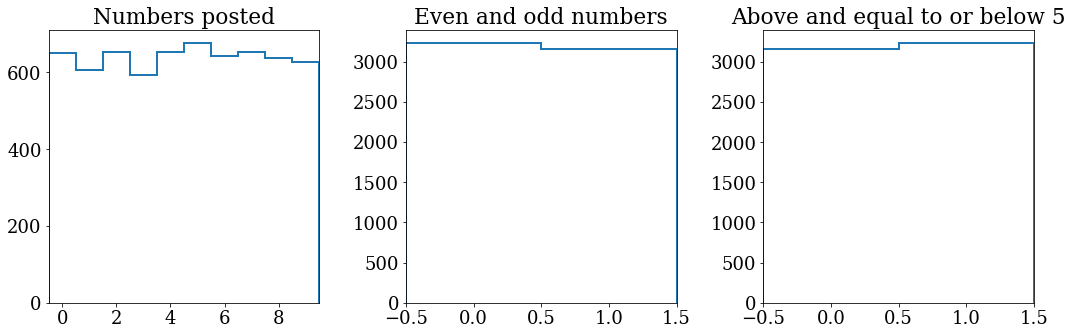

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
ax_number, ax_odd_even, ax_high_low = ax.flatten()

# Fill 1d histograms and plot them:
hist_numbers  = create_1d_hist(ax_number,   numbers,     10, (-0.5, 9.5), 'Numbers posted')                # Plot all digits
hist_odd_even = create_1d_hist(ax_odd_even, numbers % 2,  2, (-0.5, 1.5), 'Even and odd numbers')          # Is number even or odd
hist_high_low = create_1d_hist(ax_high_low, numbers // 5, 2, (-0.5, 1.5), 'Above and equal to or below 5') # Is number >= or < 5
fig.tight_layout()

### Comments on even/odd histogram:

What would you expect this distribution to be? Think about it, and then ask, if the distribution observed in data truly follows your expectation. Afterwards, think about the many other tests, that you can perform.

### Note on general goal of hypothesis tests:
Given the outcome of some test, you should try to convert it to a probability or number of sigmas (same thing). Thus determine what you expect, and then see what you observe and what error your observation has... and determine if this is consistent with the (null) hypothesis, that the data is truly random digits.

---
## Calculate the $\chi^{2}$ given a constant value (Constant is not a free parameter here)

In [27]:
chi2_ndf_number_hist   = get_chi2_ndf( hist_numbers,  1.0 / 10)
chi2_ndf_odd_even_hist = get_chi2_ndf( hist_odd_even, 1.0 / 2 )
chi2_ndf_high_low_hist = get_chi2_ndf( hist_high_low, 1.0 / 2 )

In [28]:
# Write your result: 
print("Compatability that distributions stem from random numbers : ")
print("Raw digits: Prob(Chi2={:6.2f}, Ndof={:2d}) = {:10.8f}".format(chi2_ndf_number_hist[0], chi2_ndf_number_hist[1], 
                                                             stats.chi2.sf(chi2_ndf_number_hist[0], chi2_ndf_number_hist[1])))
print("Odd/Even:   Prob(Chi2={:6.2f}, Ndof={:2d}) = {:10.8f}".format(chi2_ndf_odd_even_hist[0], chi2_ndf_odd_even_hist[1], 
                                                             stats.chi2.sf(chi2_ndf_odd_even_hist[0], chi2_ndf_odd_even_hist[1])))
print("High/Low:   Prob(Chi2={:6.2f}, Ndof={:2d}) = {:10.8f}".format(chi2_ndf_high_low_hist[0], chi2_ndf_high_low_hist[1], 
                                                             stats.chi2.sf(chi2_ndf_high_low_hist[0], chi2_ndf_high_low_hist[1])))

Compatability that distributions stem from random numbers : 
Raw digits: Prob(Chi2=  9.01, Ndof=10) = 0.53089775
Odd/Even:   Prob(Chi2=  0.95, Ndof= 2) = 0.62118441
High/Low:   Prob(Chi2=  1.10, Ndof= 2) = 0.57567725


## Compare sequence frequency with Poisson hypothesis (for sequence length 3):

The probability of any specific sequence of three digits has probability $1/1000$ for random numbers. With $N$ digits (roughly 5000 here), each sequence should be represented $lambda = N/1000$ times, and as $p$ of a specific sequence is small and the number of sequences $N$ is large, the distribution of sequence frequency should follow a Poisson distribution. This is tested below.

In [29]:
# Poisson:
# -------------
def func_Poisson(x, N, lamb) :
    if (x > -0.5) :
        return N * stats.poisson.pmf(x, lamb)
    else : 
        return 0.0
    
func_Poisson_vec = np.vectorize(func_Poisson)

### Count how many of each sequency:

Thus, for sequences of length 3 there are 1000 posibilities, which are then counted in a histogram spanning 1000 bins. This works for all seqence lengths!

In [30]:
seq = []
for i in range(-2, len(numbers)-2) : 
    seq.append(100*numbers[i] + 10*numbers[i+1] + numbers[i+2])
seq = np.array(seq)

# Put it into a histogram, which spans all possible outcomes:
poisson_counts, _ = np.histogram(seq, 1001, range=(-0.5, 1000.5))

### Plotting the distribution (in the relevant range):

Note the binning, which is (again) made to match integers in a range (this little trick/choice is very useful):

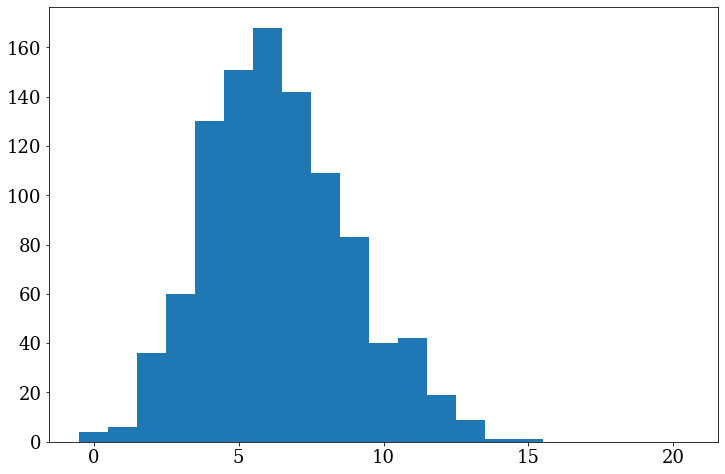

In [31]:
Nbins = 21
xmin, xmax = -0.5, 20.5

fig3, ax3 = plt.subplots(figsize=(12,8))
hist_poisson3 = ax3.hist(poisson_counts, Nbins, range=(xmin, xmax))

counts, x_edges, _ = hist_poisson3
x_centers = 0.5*(x_edges[1:] + x_edges[:-1])

In [32]:
x = x_centers[counts>0]
y = counts[counts>0]
sy = np.sqrt(y)

chi2_object = Chi2Regression(func_Poisson, x, y, sy)
minuit = Minuit(chi2_object, pedantic=False, N=1000, lamb=poisson_counts.mean())
minuit.migrad()     # Launch the fit

chi2_val = minuit.fval
N_DOF = len(y) - len(minuit.args)
chi2_prob = stats.chi2.sf(chi2_val, N_DOF)
print("The Poisson fit yields a probability of {:8.6f}".format(chi2_prob))

The Poisson fit yields a probability of 0.040145


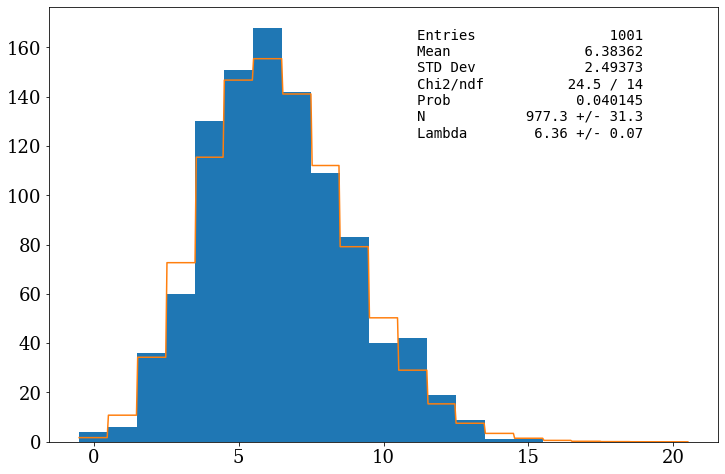

In [33]:
d = {'Entries'  : "{:d}".format(len(poisson_counts)),
     'Mean'     : "{:.5f}".format(poisson_counts.mean()),
     'STD Dev'  : "{:.5f}".format(poisson_counts.std(ddof=1)),
     'Chi2/ndf' : "{:.1f} / {:2d}".format(chi2_val, N_DOF),
     'Prob'     : "{:.6f}".format(chi2_prob),
     'N'        : "{:.1f} +/- {:.1f}".format(minuit.values['N'], minuit.errors['N']),
     'Lambda'   : "{:.2f} +/- {:.2f}".format(minuit.values['lamb'], minuit.errors['lamb'])
    }

ax3.text(0.55, 0.95, nice_string_output(d),
    family='monospace',
    transform=ax3.transAxes, fontsize=14,
    verticalalignment='top');

binwidth = (xmax-xmin) / Nbins 
xaxis = np.linspace(xmin, xmax, 500)
yaxis = binwidth*func_Poisson_vec(np.floor(xaxis+0.5), *minuit.args)
ax3.plot(xaxis, yaxis)
fig3

Questions:
---
 1. Discuss with your peers, what criteria truly random numbers should satisfy, and how these criteria can be tested.
    Based on this and on the discussion in class, write up such tests, and run all the datasets through your tests to
    see if some do not seem to be truly random.

*Example Solution to problem 1*:<br>

There is a near infinity of possible tests, but an example list of the simplest could be:
 - Runs test of even-odd, high-low, and in fact any division of the numbers (also un-even size groups).
 - ChiSquare test of distribution of sequences of digits. Given about 6000 digits, test of 1-5 lengths sequences makes good sense.
 - Check of (cor)relation between digits with a certain distance between them, to check for copies or shifts of data. Thus the 2 sequence test with N digits between them still has 100 outcomes, which for truly random numbers (null hypothesis) should be evenly distributed.
 - Kolmogorov-Smirnov test of distribution of digit frequences (to check if there is a shift too "slow" to be detected by the ChiSquare.
 - Consider sums of N consequtive numbers, where again the distrution of truly random digits is known.


 2. While one dataset is truly random, another consists of decimals from $\pi$. Apart from your own data, the other
    data sets are the result of using random numbers, but applying shifting, copying, and using biased selections.
    The non-human data sets are thus supposedly more regular (in some sense) than the humanly generated one. See if
    you can determine which one is "your" (humanly generated) data.

*Example Solution to problem 2*:<br>

The true source of the different files is given below. The human/student file should be the easiest to spot, as there is data enough for it to fail several simple tests. The truly random and pi digits are truly random, and thus it requires the pi-digit file to tell which is which. The "100 digits with shift" and "7th digit copied from 5 positions earlier" would be clearly detected by the third test suggested above, as it will for N=100 give perfect correlation! The Icecube data and Four Gaussians both suffer in their digit frequency, but in different ways, which should make these possible to spot.

The different datasets were distributed as follows (thus "D" was the humanly produced from the questionaire):

* data_RandomDigits2021_100WithShift $\rightarrow$ G
* data_RandomDigits2021_7thCopiedFrom5before.txt $\rightarrow$ F
* data_RandomDigits2021_TrulyRandom.txt $\rightarrow$ E
* data_RandomDigits2021_FromStudents.txt $\rightarrow$ D
* data_RandomDigits2021_DigitsOfPi.txt $\rightarrow$ A
* data_RandomDigits2021_IceCubedata.txt $\rightarrow$ B
* data_RandomDigits2021_FourGaussians.txt $\rightarrow$ C